In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
class CNN(nn.Module):
    def __init__(self, in_channels):
        super(CNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 2, 1),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.layers(x)


In [22]:
center = (16, 16)
x = torch.zeros(1, 1, 32, 32)
x[:, :, center[0]-2:center[0]+2, center[1]-2:center[1]+2] = 1

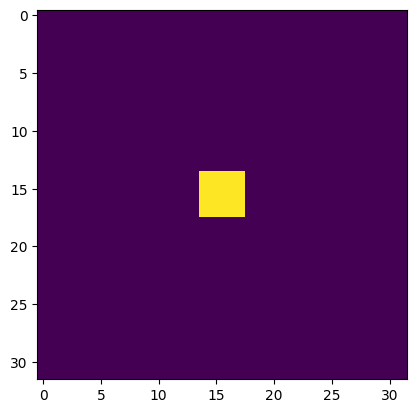

In [23]:
plt.imshow(x[0, 0, :, :])

In [24]:
cnn = CNN(1)

In [25]:
conv_out = cnn(x).flatten()

In [28]:
center_new = (10, 10)
x_new = torch.zeros(1, 1, 32, 32)
x_new[:, :, center_new[0]-2:center_new[0]+2, center_new[1]-2:center_new[1]+2] = 1

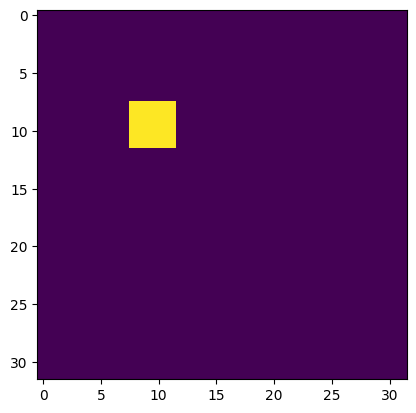

In [29]:
plt.imshow(x_new[0, 0, :, :])

In [30]:
conv_out_new = cnn(x_new).flatten()